In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.utils import plot_model
from scipy.spatial.distance import cdist, cosine
import matplotlib.pyplot as plt
from tensorboard.plugins import projector
import joblib

2023-02-10 15:01:46.522985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 15:01:46.700208: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-10 15:01:47.568746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-10 15:01:47.568947: W tensorfl

In [2]:
df = pd.read_csv('Cleaned_Data/player_cleaned_encoded.csv')
df

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,...,0,0,3,5,0,1,0,1,1,0
1,1,20801,Cristiano Ronaldo,"LW, LM",92,92,79000000.0,375000.0,29,185,...,0,0,5,4,0,0,0,1,1,0
2,2,9014,A. Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,180,...,0,0,2,5,1,-1,0,2,1,0
3,3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,...,0,0,5,4,0,1,0,1,1,0
4,5,41,Iniesta,"CM, LW",89,89,36000000.0,250000.0,30,170,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,19234,261962,Song Defu,CDM,47,52,70000.0,1000.0,22,180,...,0,0,5,3,0,0,0,0,0,0
126284,19235,262040,C. Porter,CM,47,59,110000.0,500.0,19,175,...,0,0,5,3,0,0,0,0,0,0
126285,19236,262760,N. Logue,CM,47,55,100000.0,500.0,21,178,...,0,0,5,3,0,0,0,0,0,0
126286,19237,262820,L. Rudden,ST,47,60,110000.0,500.0,19,173,...,0,0,5,3,0,0,0,0,0,0


In [3]:
### Try different feature set

all_columns = ['sofifa_id', 'short_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 
           'age', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'club_position', 'nationality_name', 
           'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'player_tags', 
           'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
           'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
           'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
           'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
           'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
           'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
           'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
           'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed', 
           'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
           'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 
           'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 
           'gk', 'season', 'diff', 
           'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot', 
           'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser', 'Takes Finesse Free Kicks', 
           'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot', 'Long Passer', 'Set Play Specialist', 'Chip Shot', 
           'Diver', 'Team Player', 'Injury Free', 'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 
           'Long Shot Taker', 'Long Throw-in', 'Backs Into Player', 'Target Forward', 'Speedster', 'Complete Defender', 'Dribbler', 
           'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 'Complete Midfielder', 'Engine', 
           'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter', 'Strength', 
           'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky', 'body_Unique', 'right_foot', 'left_foot', 
           'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits', 'defending_traits']

### selected columns
columns = ['overall', 'potential', 
           #'age', 'height_cm', 'weight_kg', 'league_level', 
           'height_cm', 'weight_kg',
           'skill_moves', #'international_reputation', 
           'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
           'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
           'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
           'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
           'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
           'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
           'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
           'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
           'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 
           'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 
           #### Traits
           'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot', 
           'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser', 'Takes Finesse Free Kicks', 
           'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot', 'Long Passer', 'Set Play Specialist', 'Chip Shot', 
           'Diver', 'Team Player', 'Injury Free', 'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 
           'Long Shot Taker', 'Long Throw-in', 'Backs Into Player', 'Target Forward', 
           #### Tags (Remove)
           #'Speedster', 'Complete Defender', 'Dribbler', 
           #'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 'Complete Midfielder', 'Engine', 
           #'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter', 'Strength', 
           
           #### Newly created
           'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky', 'body_Unique', 'right_foot', 'left_foot', 
           'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits', 'defending_traits']

In [4]:
df[columns]

,overall,potential,height_cm,weight_kg,skill_moves,pace,shooting,passing,dribbling,defending,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,93,95,169,67,4,93.0,89.0,86.0,96.0,27.0,...,0,0,3,5,0,1,0,1,1,0
1,92,92,185,80,5,93.0,93.0,81.0,91.0,32.0,...,0,0,5,4,0,0,0,1,1,0
2,90,90,180,80,4,93.0,86.0,83.0,92.0,32.0,...,0,0,2,5,1,-1,0,2,1,0
3,90,90,195,95,4,76.0,91.0,81.0,86.0,34.0,...,0,0,5,4,0,1,0,1,1,0
4,89,89,170,65,4,75.0,72.0,89.0,91.0,59.0,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,47,52,180,64,2,58.0,35.0,46.0,48.0,42.0,...,0,0,5,3,0,0,0,0,0,0
126284,47,59,175,70,2,59.0,39.0,50.0,46.0,41.0,...,0,0,5,3,0,0,0,0,0,0
126285,47,55,178,72,2,60.0,37.0,45.0,49.0,41.0,...,0,0,5,3,0,0,0,0,0,0
126286,47,60,173,66,2,68.0,46.0,36.0,48.0,15.0,...,0,0,5,3,0,0,0,0,0,0


In [5]:
### Train test Split
X = df[columns].copy()
# Target
y = df['overall']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape

(107344, 111)

In [8]:
emb_dim = 20
input = tf.keras.layers.Input(shape=X_train.shape[1:])

encoder = tf.keras.layers.Dense(X_train.shape[1:][0], activation='relu')(input)
encoder = tf.keras.layers.Dense(100, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(75, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(50, activation='relu')(encoder)
embedding = tf.keras.layers.Dense(emb_dim, activation='relu',name='embedding')(encoder)

decoder = tf.keras.layers.Dense(50, activation='relu')(embedding)
decoder = tf.keras.layers.Dense(75, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(100, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoder),

autoencoder = Model(input, decoder)

autoencoder.compile(loss='mae', optimizer='adam')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111)]             0         
                                                                 
 dense (Dense)               (None, 111)               12432     
                                                                 
 dense_1 (Dense)             (None, 100)               11200     
                                                                 
 dense_2 (Dense)             (None, 75)                7575      
                                                                 
 dense_3 (Dense)             (None, 50)                3800      
                                                                 
 embedding (Dense)           (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 50)                1050  

2023-02-10 15:01:53.042556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:01:53.054001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:01:53.055838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:01:53.058151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

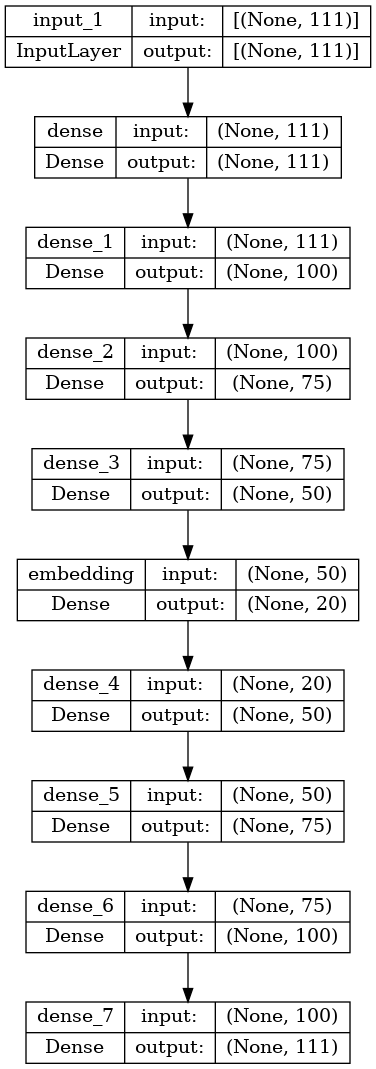

In [9]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder.png')

In [10]:
callback = EarlyStopping(monitor='loss', patience=3)

history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2, #shuffle=False, 
                callbacks=[callback], validation_data = (X_test, X_test))

Epoch 1/100
3355/3355 [==============================] - 13s 3ms/step - loss: 0.0529 - val_loss: 0.0453
Epoch 2/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0428 - val_loss: 0.0367
Epoch 3/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0357 - val_loss: 0.0356
Epoch 4/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0340 - val_loss: 0.0331
Epoch 5/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0328 - val_loss: 0.0326
Epoch 6/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 7/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0319 - val_loss: 0.0317
Epoch 8/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0315 - val_loss: 0.0315
Epoch 9/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0313 - val_loss: 0.0311
Epoch 10/100
3355/3355 [==============================] - 11s 3m

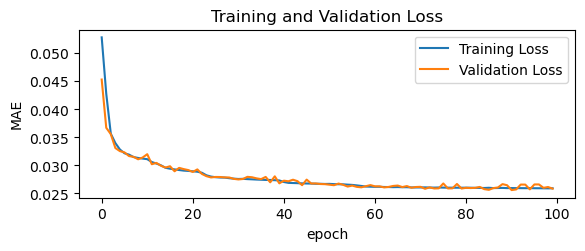

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MAE')
#plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
player_embedding = Model(input, embedding)

test = player_embedding.predict(X_test)
test

592/592 [==============================] - 1s 1ms/step


array([[2.3574176 , 1.2768563 , 0.9316037 , ..., 0.59975076, 0.46215555,
        0.57496035],
       [0.99326646, 0.4079355 , 2.207017  , ..., 1.280534  , 0.8678468 ,
        1.0412744 ],
       [1.3473905 , 0.66656625, 1.0029353 , ..., 1.1982056 , 0.25158092,
        0.68964744],
       ...,
       [1.1739539 , 1.0606933 , 1.3664563 , ..., 0.4287876 , 0.5587434 ,
        0.20890078],
       [1.031823  , 0.7077848 , 1.978354  , ..., 0.9951677 , 0.5197211 ,
        0.52811635],
       [1.5020369 , 1.1549481 , 1.8561076 , ..., 0.20050818, 0.49398598,
        0.80240846]], dtype=float32)

In [13]:
test[0]

array([2.3574176 , 1.2768563 , 0.9316037 , 0.        , 1.1593689 ,
       0.4348701 , 0.        , 0.        , 0.6540276 , 0.        ,
       1.1206769 , 1.0722767 , 0.        , 0.        , 1.7927098 ,
       2.3777416 , 0.6720346 , 0.59975076, 0.46215555, 0.57496035],
      dtype=float32)

In [14]:
messi_1415 = df[df['short_name']== 'L. Messi'][columns].head(1).to_numpy()
messi_test = scaler.transform(messi_1415)
messi_test

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


array([[0.98148148, 1.        , 0.3       , 0.29508197, 0.75      ,
        0.94736842, 0.9375    , 0.90410959, 1.        , 0.16883117,
        0.5625    , 0.87951807, 0.98823529, 0.71084337, 0.92      ,
        0.90361446, 0.98823529, 0.93975904, 0.94117647, 0.7625    ,
        1.        , 0.98701299, 0.90789474, 0.97333333, 0.97058824,
        0.975     , 0.81176471, 0.68831169, 0.74025974, 0.51898734,
        0.92771084, 0.44186047, 0.14457831, 0.95294118, 0.92941176,
        0.76470588, 0.88461538, 0.20689655, 0.13095238, 0.11764706,
        0.96875   , 0.96875   , 0.96875   , 1.01470588, 0.98507463,
        0.98507463, 0.98507463, 1.01470588, 1.01515152, 1.01515152,
        1.01515152, 0.98461538, 0.828125  , 0.828125  , 0.828125  ,
        0.98461538, 0.62903226, 0.59677419, 0.59677419, 0.59677419,
        0.62903226, 0.49180328, 0.34848485, 0.34848485, 0.34848485,
        0.49180328, 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.  

In [15]:
messi_embedding = player_embedding.predict(messi_test)
messi_embedding

1/1 [==============================] - 0s 77ms/step


array([[3.2656667 , 0.7571471 , 1.7093608 , 0.        , 1.8707894 ,
        0.        , 0.        , 0.        , 0.9320921 , 0.        ,
        1.0502024 , 0.77939737, 0.        , 0.        , 3.5477762 ,
        2.5358388 , 0.9146757 , 1.2841816 , 1.3379102 , 1.2946601 ]],
      dtype=float32)

In [16]:
norm_players = scaler.transform(df[columns])

enc_players = pd.DataFrame(player_embedding.predict(norm_players))
enc_players = enc_players.add_prefix('feature_')
enc_players

3947/3947 [==============================] - 5s 1ms/step


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,3.265667,0.757148,1.709361,0.0,1.870791,0.000000,0.0,0.0,0.932092,0.0,1.050203,0.779398,0.0,0.0,3.547777,2.535839,0.914676,1.284182,1.337910,1.294660
1,3.758625,1.209742,1.564240,0.0,0.474581,0.460083,0.0,0.0,0.521481,0.0,1.467055,0.986364,0.0,0.0,2.773616,2.456737,0.486339,0.508786,0.510534,1.164134
2,2.898894,1.266350,1.875545,0.0,1.957869,0.040286,0.0,0.0,0.886252,0.0,0.966359,0.767043,0.0,0.0,3.300267,2.276494,1.297398,0.690070,0.657781,1.098054
3,3.622704,1.384349,1.968731,0.0,0.689646,0.611457,0.0,0.0,0.577605,0.0,0.934327,0.825177,0.0,0.0,2.274490,1.901708,0.385015,1.425968,0.401931,0.913824
4,2.284001,1.387072,2.395956,0.0,1.186806,0.054275,0.0,0.0,1.419867,0.0,0.816368,1.042094,0.0,0.0,2.159883,2.955362,0.189032,0.535730,0.991364,1.050213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,0.463187,0.528406,0.896661,0.0,0.989502,1.371228,0.0,0.0,0.669588,0.0,0.600177,0.927473,0.0,0.0,0.705463,1.019581,0.764323,0.865071,0.617943,0.469705
126284,0.459426,0.739470,0.860212,0.0,0.998605,1.291639,0.0,0.0,0.672569,0.0,0.471460,0.524431,0.0,0.0,0.756158,1.039984,0.670673,0.754113,0.496114,0.379089
126285,0.583554,0.534359,0.883899,0.0,1.025931,1.386753,0.0,0.0,0.701014,0.0,0.592992,0.746789,0.0,0.0,0.712209,0.987118,0.721504,1.002327,0.550613,0.527887
126286,0.524298,0.523198,0.106561,0.0,1.139934,1.555437,0.0,0.0,0.601059,0.0,0.505016,0.555318,0.0,0.0,1.317611,0.408143,0.491084,1.087960,0.779156,0.582551


In [17]:
player_embedding_df = df[['sofifa_id','short_name','season']].join(enc_players)
player_embedding_df[player_embedding_df['sofifa_id'] == 158023]

,sofifa_id,short_name,season,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,158023,L. Messi,1415,3.265667,0.757148,1.709361,0.0,1.870791,0.0,0.0,...,1.050203,0.779398,0.0,0.0,3.547777,2.535839,0.914676,1.284182,1.337910,1.294660
14380,158023,L. Messi,1516,3.246406,0.807521,1.621410,0.0,2.192120,0.0,0.0,...,1.100798,0.843648,0.0,0.0,3.447260,2.568624,0.887763,1.365363,1.271545,1.224468
28305,158023,L. Messi,1617,3.291055,0.792303,1.858379,0.0,2.338110,0.0,0.0,...,1.092991,0.911042,0.0,0.0,3.439387,2.595409,0.779072,1.414103,1.301427,1.353067
43908,158023,L. Messi,1718,3.285463,0.802034,1.893558,0.0,2.406103,0.0,0.0,...,1.097532,0.935632,0.0,0.0,3.472732,2.578111,0.823707,1.415394,1.293549,1.365096
59843,158023,L. Messi,1819,3.385196,0.747430,2.103769,0.0,2.436939,0.0,0.0,...,1.049339,0.969589,0.0,0.0,3.431670,2.777207,0.796833,1.467861,1.355075,1.453514
75898,158023,L. Messi,1920,3.390594,0.789890,2.251783,0.0,2.387784,0.0,0.0,...,1.011582,0.954038,0.0,0.0,3.219703,2.858524,0.813560,1.302438,1.172862,1.320720
92320,158023,L. Messi,2021,3.251679,0.739207,2.096639,0.0,2.333354,0.0,0.0,...,1.062284,0.973292,0.0,0.0,3.135972,2.592942,0.724145,1.264999,1.068418,1.242288
109181,158023,L. Messi,2122,3.277789,0.756204,2.087990,0.0,2.391356,0.0,0.0,...,1.061939,0.993348,0.0,0.0,3.206786,2.578200,0.697631,1.272186,1.085044,1.243395


In [18]:
player_embedding_df[player_embedding_df['sofifa_id'] == 20801]

,sofifa_id,short_name,season,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
1,20801,Cristiano Ronaldo,1415,3.758625,1.209742,1.564240,0.0,0.474581,0.460083,0.0,...,1.467055,0.986364,0.0,0.0,2.773616,2.456737,0.486339,0.508786,0.510534,1.164134
14381,20801,Cristiano Ronaldo,1516,3.953484,1.234891,1.221004,0.0,0.894786,0.392471,0.0,...,1.484095,1.136445,0.0,0.0,2.346539,2.661075,0.461978,0.602689,0.593610,1.076918
28304,20801,Cristiano Ronaldo,1617,4.126410,1.259415,1.360926,0.0,0.948438,0.404244,0.0,...,1.478321,1.046704,0.0,0.0,2.421443,2.830358,0.374458,0.605529,0.769751,1.149873
43907,20801,Cristiano Ronaldo,1718,4.122661,1.222620,1.456111,0.0,0.988493,0.391356,0.0,...,1.382363,1.027919,0.0,0.0,2.423369,2.852642,0.299847,0.576179,0.748574,1.174775
59842,20801,Cristiano Ronaldo,1819,4.006461,1.190789,1.405771,0.0,0.936381,0.394350,0.0,...,1.362876,1.074068,0.0,0.0,2.313507,2.750958,0.377921,0.566794,0.707652,1.149878
75899,20801,Cristiano Ronaldo,1920,3.900682,1.209164,1.359931,0.0,0.960872,0.393667,0.0,...,1.361175,1.191480,0.0,0.0,2.258801,2.686778,0.383697,0.578707,0.627145,1.102183
92321,20801,Cristiano Ronaldo,2021,3.834217,1.204510,1.353389,0.0,0.963532,0.410044,0.0,...,1.371825,1.212015,0.0,0.0,2.213944,2.635492,0.384664,0.557345,0.621467,1.073263
109183,20801,Cristiano Ronaldo,2122,3.613979,1.164247,1.252119,0.0,0.892797,0.388208,0.0,...,1.406765,1.354038,0.0,0.0,2.109154,2.418509,0.475486,0.523884,0.583081,0.858698


In [19]:
enc_players.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
count,126288.000000,126288.000000,126288.000000,126288.0,126288.000000,126288.000000,126288.0,126288.0,126288.000000,126288.0,126288.000000,126288.000000,126288.0,126288.0,126288.000000,126288.000000,126288.000000,126288.000000,126288.000000,126288.000000
mean,1.337036,0.793032,1.590389,0.0,1.009542,1.224469,0.0,0.0,0.675895,0.0,0.678217,0.698751,0.0,0.0,1.230872,1.462585,1.009483,0.855025,0.564414,0.656900
std,0.473089,0.334042,0.600362,0.0,0.585079,0.407585,0.0,0.0,0.250506,0.0,0.295961,0.253384,0.0,0.0,0.509288,0.521056,0.520764,0.347947,0.197297,0.229319
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.006538,0.545928,1.154943,0.0,0.576245,0.943427,0.0,0.0,0.501997,0.0,0.458648,0.530732,0.0,0.0,0.851930,1.108386,0.610787,0.560279,0.433675,0.502195
50%,1.336102,0.737759,1.612080,0.0,0.824333,1.191670,0.0,0.0,0.662499,0.0,0.658230,0.687022,0.0,0.0,1.209635,1.454655,0.879823,0.922950,0.558985,0.652039
75%,1.651969,1.029388,2.018183,0.0,1.381951,1.471834,0.0,0.0,0.837159,0.0,0.866897,0.853868,0.0,0.0,1.571450,1.802256,1.315360,1.104382,0.687836,0.806074
max,4.126410,2.482191,3.805357,0.0,3.361869,3.454065,0.0,0.0,1.836275,0.0,2.285789,2.118580,0.0,0.0,3.598920,3.879876,3.249082,2.146194,1.481049,1.697473


In [20]:
player_embedding_df.to_csv('player_embedding.csv')
!zip player_embedding.csv.zip player_embedding.csv

updating: player_embedding.csv (deflated 57%)


In [21]:
df[df['short_name'].str.contains('Ødegaard')][['sofifa_id','short_name','season','club_name']]

,sofifa_id,short_name,season,club_name
8776,202259,M. Ødegaard,1415,Lillestrøm SK
18926,222665,M. Ødegaard,1516,Real Madrid CF
22611,202259,M. Ødegaard,1516,Tromsø IL
33180,222665,M. Ødegaard,1617,Real Madrid CF
37257,202259,M. Ødegaard,1617,Tromsø IL
46177,222665,M. Ødegaard,1718,SC Heerenveen
53990,202259,M. Ødegaard,1718,Tromsø IL
62100,222665,M. Ødegaard,1819,Real Madrid CF
67942,202259,M. Ødegaard,1819,Tromsø IL
76742,222665,M. Ødegaard,1920,Real Sociedad


In [22]:
def closest_players(player_idx=0, metric='euclid', year='all'):
    player_edist = cdist(player_embedding_df.iloc[player_idx:player_idx+1, 3:], player_embedding_df.iloc[:,3:], metric)
    tmp = player_embedding_df.copy()
    tmp['Similarity'] = player_edist.reshape(126288, 1)
    close_idx = np.argsort(player_edist)[0]
    tmp = tmp.iloc[close_idx]
    season = player_embedding_df.iloc[player_idx].season
    tmp = tmp[tmp['sofifa_id'] != player_embedding_df.iloc[player_idx].sofifa_id ]
    if year =='same':
        tmp = tmp[tmp['season'] == season ]
    #return tmp.iloc[close_idx][['sofifa_id','short_name','season','Similarity']]
    return tmp.iloc[1:31][['sofifa_id','short_name','season','Similarity']]

player_idx = 109401
#closest_players(player_idx)
closest_players(player_idx,'cosine','all')

,sofifa_id,short_name,season,Similarity
60101,212404,F. Bernardeschi,1819,0.005008
110464,244261,L. Majer,2122,0.005130
92704,212404,F. Bernardeschi,2021,0.005830
59956,183898,Á. Di María,1819,0.006671
75945,183898,Á. Di María,1920,0.006713
43975,183898,Á. Di María,1718,0.006768
109287,208670,H. Ziyech,2122,0.007798
76560,244369,V. Tsygankov,1920,0.007911
28335,183898,Á. Di María,1617,0.007965
60697,142966,J. Dátolo,1819,0.008031


In [23]:
autoencoder.save('models/autoencoder/')
player_embedding.save('models/encoder/')
joblib.dump(scaler, 'models/minmaxscaler.joblib') 

INFO:tensorflow:Assets written to: models/autoencoder/assets
INFO:tensorflow:Assets written to: models/encoder/assets


['models/minmaxscaler.joblib']

## Properties
#### The model encodes players is named player_embedding
#### Use scaler to transform a player and then call player_embedding.predict() to get a vector that represent a player in specific season
#### scaler, encoder model and player embedding table need to be saved